<a href="https://colab.research.google.com/github/OnlyVanzC/vanessachia.github.io/blob/master/Assignment2_Dphi_Bootcamp_Finalised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D',
                                    dest_path='/content/animals.zip',
                                    unzip=True)

Unzipping...Done.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
image_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    
    "animal_dataset_intermediate/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds =image_dataset_from_directory(
    "animal_dataset_intermediate/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 8196 files belonging to 5 classes.
Using 6557 files for training.
Found 8196 files belonging to 5 classes.
Using 1639 files for validation.


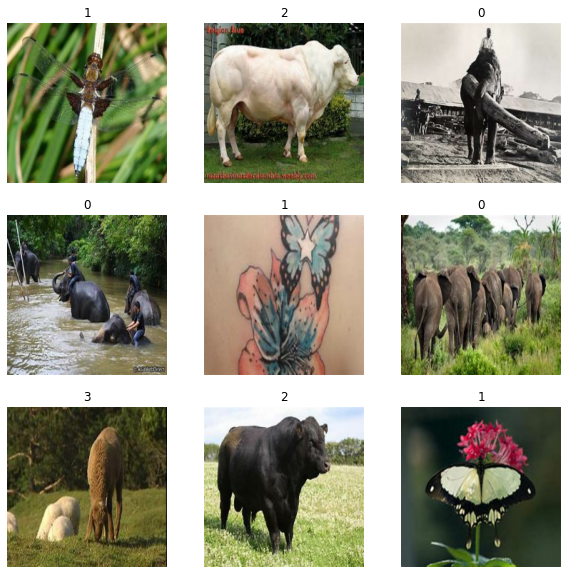

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
from tensorflow.keras import layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [7]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [8]:
#Building CNN model
from tensorflow.keras.models import Sequential

img_height = 224
img_width = 224

num_classes = 5

model_1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model_1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [11]:
epochs=10
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
205/205 [==============================] - 305s 1s/step - loss: 1.2171 - accuracy: 0.5071 - val_loss: 1.0009 - val_accuracy: 0.6187
Epoch 2/10
205/205 [==============================] - 305s 1s/step - loss: 0.8809 - accuracy: 0.6645 - val_loss: 0.8376 - val_accuracy: 0.6754
Epoch 3/10
205/205 [==============================] - 302s 1s/step - loss: 0.6704 - accuracy: 0.7487 - val_loss: 0.7805 - val_accuracy: 0.7193
Epoch 4/10
205/205 [==============================] - 305s 1s/step - loss: 0.4637 - accuracy: 0.8315 - val_loss: 0.8281 - val_accuracy: 0.7193
Epoch 5/10
205/205 [==============================] - 303s 1s/step - loss: 0.3099 - accuracy: 0.8888 - val_loss: 0.9701 - val_accuracy: 0.7084
Epoch 6/10
205/205 [==============================] - 305s 1s/step - loss: 0.1794 - accuracy: 0.9396 - val_loss: 1.1200 - val_accuracy: 0.7004
Epoch 7/10
205/205 [==============================] - 303s 1s/step - loss: 0.0940 - accuracy: 0.9710 - val_loss: 1.1879 - val_accuracy: 0.7200

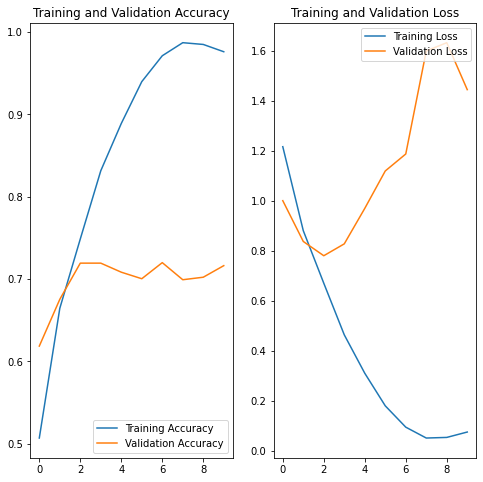

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Overfitting can be seen, thus need to optimise the model

In [13]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

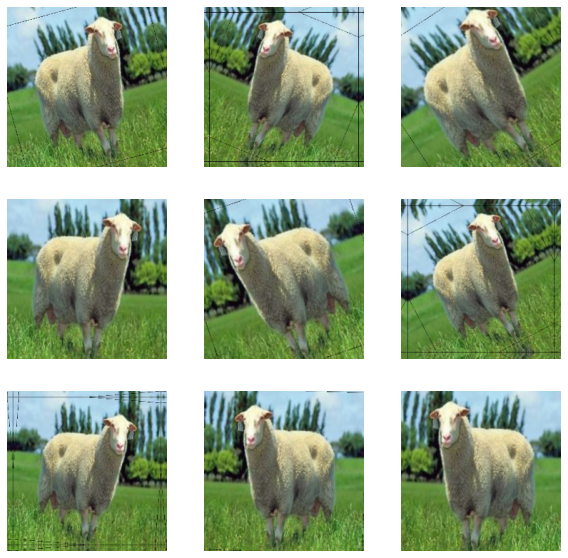

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
model_2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)       

In [18]:
epochs = 15
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
205/205 [==============================] - 357s 2s/step - loss: 1.2559 - accuracy: 0.4836 - val_loss: 1.1753 - val_accuracy: 0.5497
Epoch 2/15
205/205 [==============================] - 359s 2s/step - loss: 1.0330 - accuracy: 0.5908 - val_loss: 0.9894 - val_accuracy: 0.6168
Epoch 3/15
205/205 [==============================] - 357s 2s/step - loss: 0.9461 - accuracy: 0.6267 - val_loss: 1.1755 - val_accuracy: 0.5839
Epoch 4/15
205/205 [==============================] - 359s 2s/step - loss: 0.8545 - accuracy: 0.6745 - val_loss: 1.0920 - val_accuracy: 0.6297
Epoch 5/15
205/205 [==============================] - 358s 2s/step - loss: 0.7833 - accuracy: 0.7006 - val_loss: 0.8577 - val_accuracy: 0.6931
Epoch 6/15
205/205 [==============================] - 357s 2s/step - loss: 0.7400 - accuracy: 0.7188 - val_loss: 0.9089 - val_accuracy: 0.6833
Epoch 7/15
205/205 [==============================] - 359s 2s/step - loss: 0.6956 - accuracy: 0.7319 - val_loss: 0.8796 - val_accuracy: 0.6870

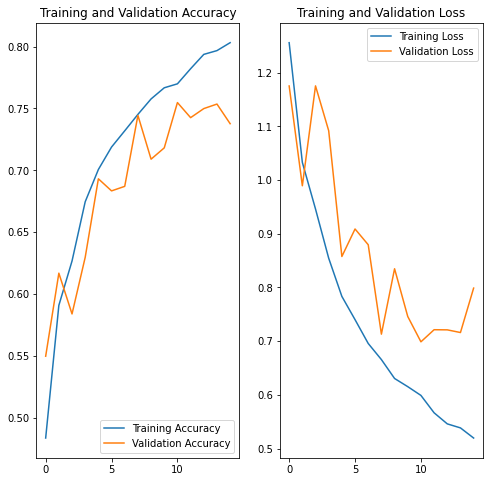

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#no overfitting can be seen. Epoch can be increased in future to increase accuracy

In [20]:
#Importing test Data
import pandas as pd

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_df = pd.read_csv("animal_dataset_intermediate/Testing_set_animals.csv")
#image_paths = [[fname, 'animal_dataset_intermediate/test/' + fname[:-4] + '.jpg'] for fname in test_label['filename']]
#test_df = test_df['filename'].replace(image_paths, inplace=True)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="animal_dataset_intermediate/test",
    x_col="filename",
    labels = "inferred",
    label_mode = 'int',
    target_size=(224, 224),
    batch_size=32,
    seed=1337,
    class_mode=None,
    shuffle=False,
)

Found 910 validated image filenames.


In [32]:

predictions = model_2.predict(test_generator)
score = tf.nn.softmax(predictions)


In [33]:
target = np.argmax(score, axis=1)

In [34]:
class_names = ['elefante','farfalla', 'mucca', 'pecora', 'scoiattolo']
final_predictions = [class_names[i] for i in target]

In [35]:
final_predictions[0]

'farfalla'

In [36]:
new_target = []

for i in final_predictions:
  new_target.append(i)

new_target

['farfalla',
 'farfalla',
 'farfalla',
 'farfalla',
 'farfalla',
 'farfalla',
 'elefante',
 'pecora',
 'scoiattolo',
 'scoiattolo',
 'scoiattolo',
 'elefante',
 'farfalla',
 'elefante',
 'mucca',
 'farfalla',
 'elefante',
 'farfalla',
 'scoiattolo',
 'mucca',
 'farfalla',
 'elefante',
 'pecora',
 'pecora',
 'pecora',
 'pecora',
 'scoiattolo',
 'farfalla',
 'farfalla',
 'farfalla',
 'scoiattolo',
 'pecora',
 'mucca',
 'pecora',
 'pecora',
 'farfalla',
 'farfalla',
 'scoiattolo',
 'mucca',
 'farfalla',
 'farfalla',
 'mucca',
 'farfalla',
 'pecora',
 'pecora',
 'pecora',
 'elefante',
 'elefante',
 'elefante',
 'elefante',
 'elefante',
 'farfalla',
 'farfalla',
 'farfalla',
 'pecora',
 'farfalla',
 'farfalla',
 'elefante',
 'farfalla',
 'farfalla',
 'pecora',
 'farfalla',
 'farfalla',
 'farfalla',
 'pecora',
 'scoiattolo',
 'pecora',
 'farfalla',
 'farfalla',
 'mucca',
 'farfalla',
 'farfalla',
 'pecora',
 'farfalla',
 'pecora',
 'farfalla',
 'scoiattolo',
 'farfalla',
 'farfalla',
 'farfa